In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Step 2: Data Retrieval

# Define the list of assets
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'JNJ', 'V', 'WMT', 'PG']

# Define the time period
start_date = '2018-01-01'
end_date = '2023-10-01'

# Fetch the adjusted closing prices
data = yf.download(assets, start=start_date, end=end_date)['Adj Close']
data.head()


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,PG,TSLA,V,WMT
Date,,,,,,,,,,
2018-01-02 00:00:00+00:00,40.568924,59.450500,53.527958,115.682434,88.566368,79.792938,75.722366,21.368668,109.311729,29.255863
2018-01-03 00:00:00+00:00,40.561855,60.209999,54.441196,116.787521,88.656616,80.164253,75.630463,21.150000,110.399994,29.511065
2018-01-04 00:00:00+00:00,40.750267,60.479500,54.652668,116.779228,89.926666,80.869820,76.165070,20.974667,110.810463,29.537764
2018-01-05 00:00:00+00:00,41.214226,61.457001,55.377377,117.743042,89.349342,81.872444,76.215202,21.105333,113.464256,29.712845
2018-01-08 00:00:00+00:00,41.061138,62.343498,55.572891,117.892578,89.481293,81.956009,76.616165,22.427334,113.922455,30.152027


In [4]:
# Step 3: Data Preprocessing

# Check for missing values
print(data.isnull().sum())

# Forward fill to handle missing data
data.ffill(inplace=True)

# Calculate daily returns
returns = data.pct_change().dropna()
returns.head()


Ticker
AAPL     0
AMZN     0
GOOGL    0
JNJ      0
JPM      0
MSFT     0
PG       0
TSLA     0
V        0
WMT      0
dtype: int64


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,PG,TSLA,V,WMT
Date,,,,,,,,,,
2018-01-03 00:00:00+00:00,-0.000174,0.012775,0.017061,0.009553,0.001019,0.004653,-0.001214,-0.010233,0.009956,0.008723
2018-01-04 00:00:00+00:00,0.004645,0.004476,0.003884,-0.000071,0.014325,0.008802,0.007069,-0.008290,0.003718,0.000905
2018-01-05 00:00:00+00:00,0.011385,0.016163,0.013260,0.008253,-0.006420,0.012398,0.000658,0.006230,0.023949,0.005927
2018-01-08 00:00:00+00:00,-0.003714,0.014425,0.003531,0.001270,0.001477,0.001021,0.005261,0.062638,0.004038,0.014781
2018-01-09 00:00:00+00:00,-0.000115,0.004676,-0.001274,0.015857,0.005069,-0.000680,-0.007305,-0.008085,-0.001927,-0.012007


In [5]:
# Step 4: Calculating Expected Returns and Covariance Matrix

# Calculate annualized expected returns
expected_returns = returns.mean() * 252

# Calculate annualized covariance matrix
cov_matrix = returns.cov() * 252

In [6]:
# Step 5: Portfolio Optimization using Mean-Variance Optimization

# Number of assets
num_assets = len(assets)

# Define the optimization variables
weights = cp.Variable(num_assets)

# Define the expected portfolio return
portfolio_return = expected_returns.values @ weights

# Define the portfolio risk (variance)
portfolio_risk = cp.quad_form(weights, cov_matrix.values)

# Define the objective function (minimize risk)
objective = cp.Minimize(portfolio_risk)

# Constraints
constraints = [
    cp.sum(weights) == 1,        # Weights sum to 1
    weights >= 0,                # No short-selling
    portfolio_return >= 0.20     # Target return of 20%
]

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Optimal weights
optimal_weights = weights.value


In [7]:
# Step 6: Incorporating Constraints and Extensions

# Let's add a maximum weight constraint per asset
max_weight = 0.20
constraints.append(weights <= max_weight)

# Re-define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Updated optimal weights
optimal_weights = weights.value


In [8]:
# Step 7: Optimization with CVXPY

# Re-run the optimization with the new constraints
problem.solve(solver=cp.SCS)

# Check if the problem is solved
print(f"Problem Status: {problem.status}")

# Optimal portfolio performance
optimal_return = expected_returns.values @ optimal_weights
optimal_risk = np.sqrt(optimal_weights.T @ cov_matrix.values @ optimal_weights)

print(f"Optimal Expected Return: {optimal_return:.2%}")
print(f"Optimal Portfolio Risk: {optimal_risk:.2%}")


Problem Status: optimal
Optimal Expected Return: 20.00%
Optimal Portfolio Risk: 19.38%


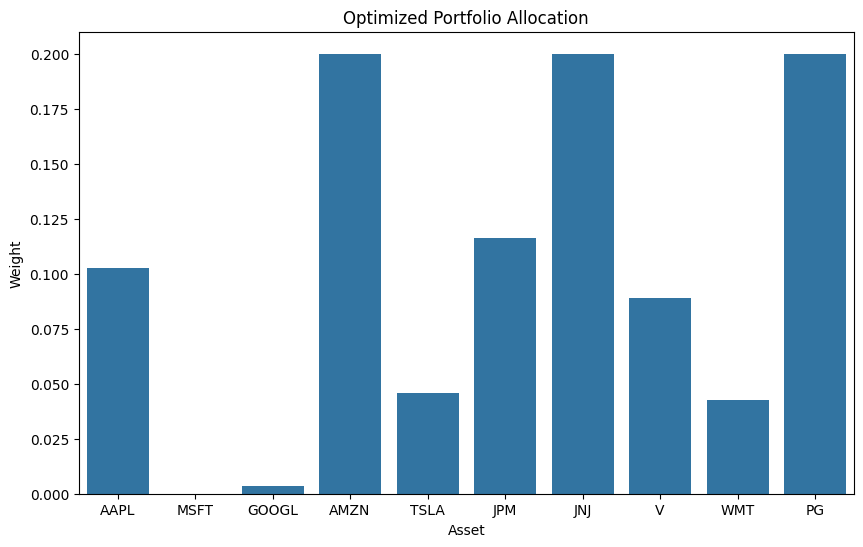

In [9]:
# Step 8: Analyzing and Visualizing the Results

# Create a DataFrame for the optimal weights
portfolio = pd.DataFrame({'Asset': assets, 'Weight': optimal_weights})

# Plot the asset allocation
plt.figure(figsize=(10, 6))
sns.barplot(x='Asset', y='Weight', data=portfolio)
plt.title('Optimized Portfolio Allocation')
plt.ylabel('Weight')
plt.xlabel('Asset')
plt.show()


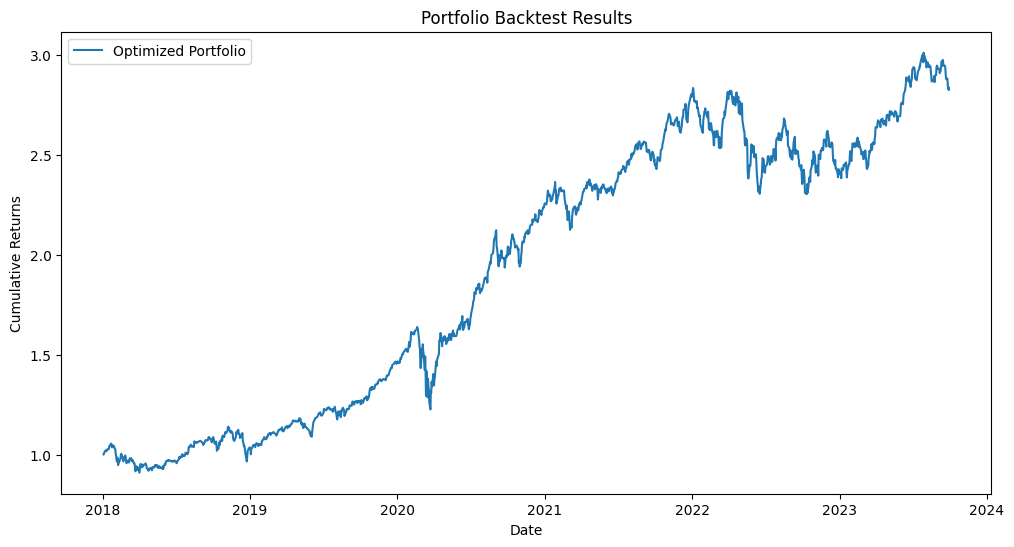

In [10]:
# Step 9: Backtesting the Optimized Portfolio

# Calculate the portfolio returns
portfolio_returns = returns @ optimal_weights

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Portfolio Backtest Results')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


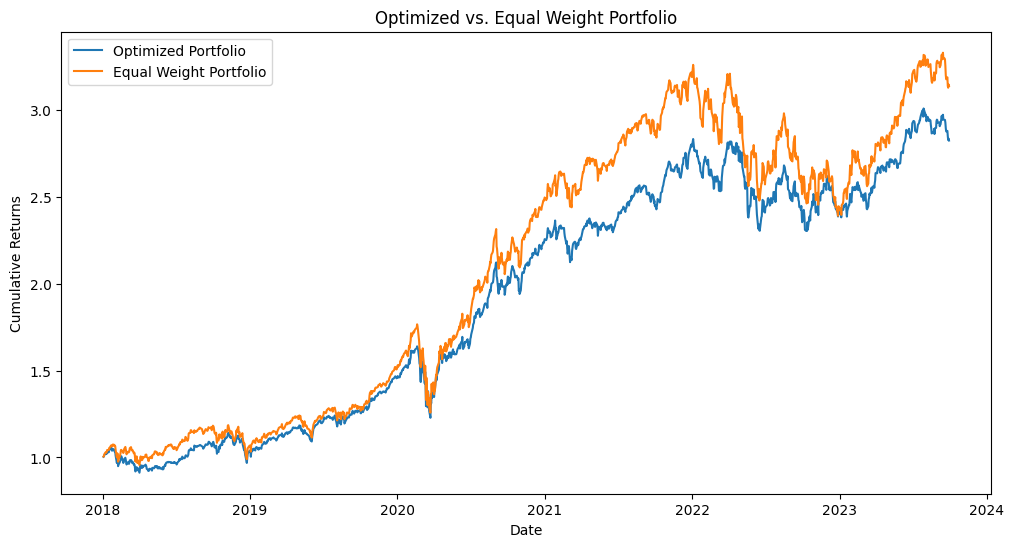

In [11]:
# Step 10: Comparing with Equal Weight Portfolio

# Equal weights
equal_weights = np.array([1/num_assets]*num_assets)

# Equal weight portfolio returns
equal_portfolio_returns = returns @ equal_weights

# Equal portfolio cumulative returns
equal_cumulative_returns = (1 + equal_portfolio_returns).cumprod()

# Plotting both portfolios
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.plot(equal_cumulative_returns, label='Equal Weight Portfolio')
plt.title('Optimized vs. Equal Weight Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
